# Import Libraries

In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
from collections import Counter

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# Read Data

In [4]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

DATA_ROOT = '/home/wsl/classwork/7015/ass1/MedMNIST'

train_dataset = DataClass(
    split='train',
    transform=data_transform,
    download=download,
    root=DATA_ROOT
)
test_dataset = DataClass(
    split='test',
    transform=data_transform,
    download=download,
    root=DATA_ROOT
)
val_dataset = DataClass(
    split='val',
    transform=data_transform,
    download=download,
    root=DATA_ROOT
)

pil_dataset = DataClass(
    split='train',
    download=download,
    root=DATA_ROOT
)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/wsl/classwork/7015/ass1/MedMNIST
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /home/wsl/classwork/7015/ass1/MedMNIST
    Split: test
    Task: binary-class
    Number of channels: 1
  

In [ ]:
# visualization

train_dataset.montage(length=1)

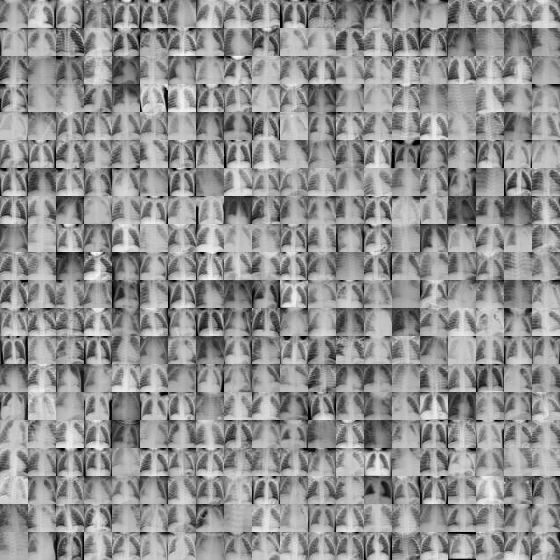

In [ ]:
# montage

train_dataset.montage(length=20)

# No Data Enhancement Binary Classification

In [ ]:
# define a simple CNN model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split, root='/content/drive/MyDrive/Colab Notebooks/MedMNIST')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 1.000  acc:1.000
test  auc: 0.956  acc:0.857


# NPZ to PNG


Available key names: ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
Saving 4708 images to /home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images/train
Saving 524 images to /home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images/val
Saving 624 images to /home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images/test
All images saved successfully.


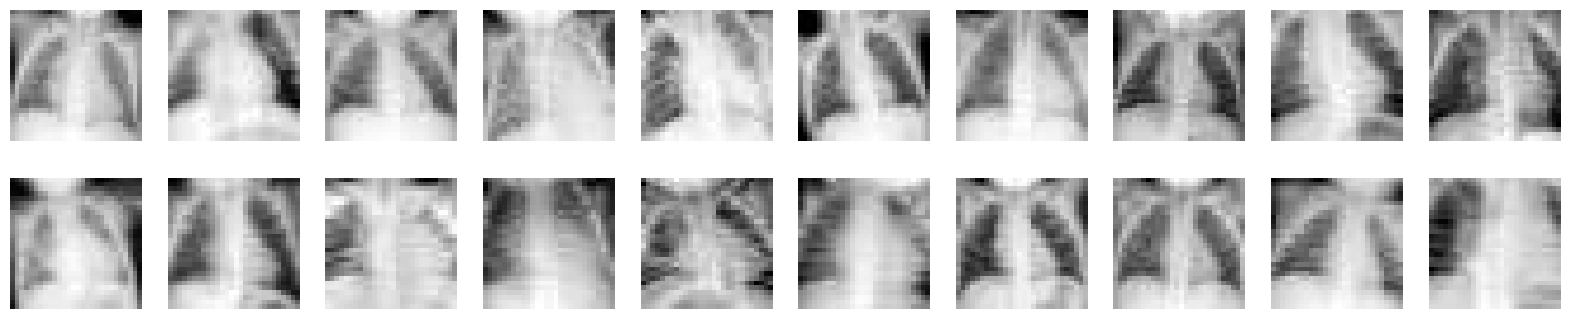

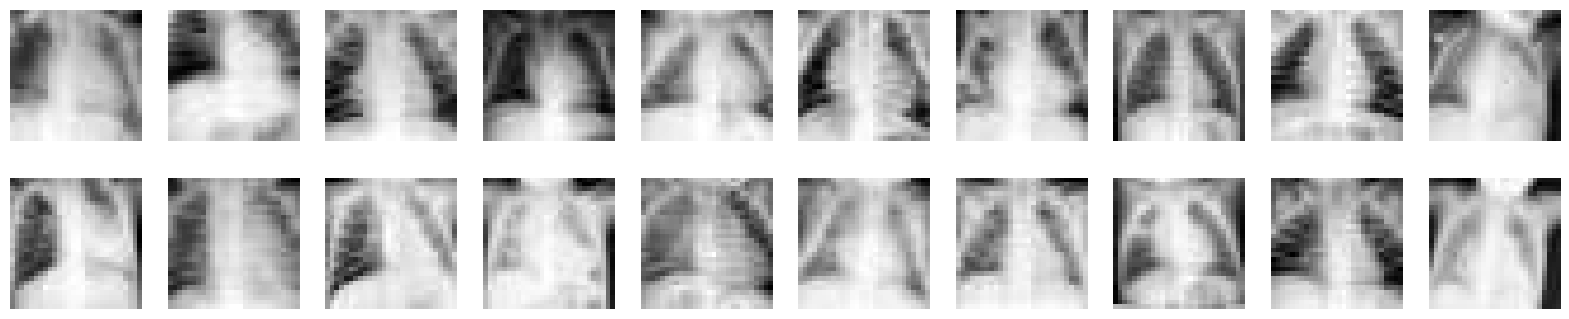

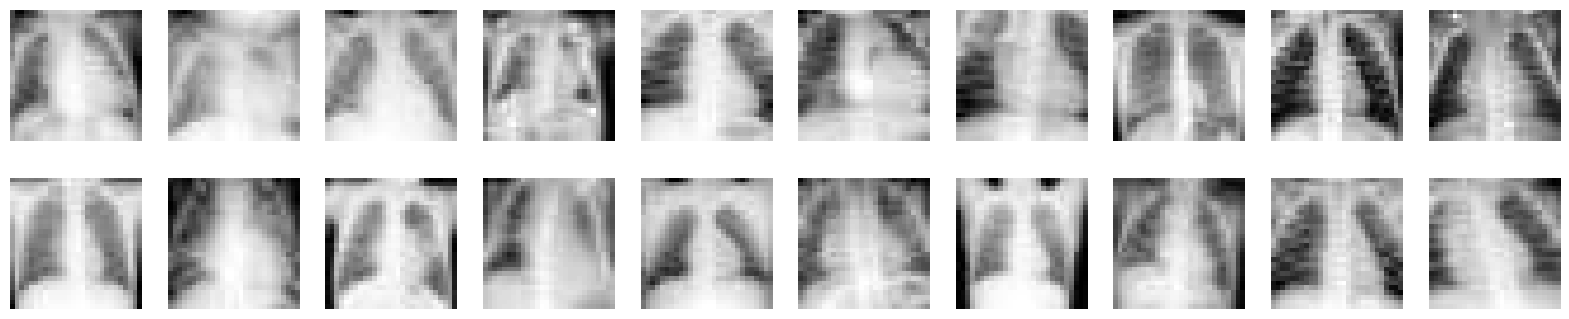

In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def save_images_from_npz(npz_path, output_dir):
    data = np.load(npz_path)

    print("Available key names:", data.files)

    splits = ['train', 'val', 'test']

    for split in splits:
        images_key = f'{split}_images'
        labels_key = f'{split}_labels'

        if images_key not in data.files:
            print(f"Warning: {images_key} does not exist in .npz file, skipping {split}.")
            continue

        images = data[images_key]
        labels = data[labels_key] if labels_key in data.files else None

        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)

        num_images = images.shape[0]
        print(f"Saving {num_images} images to {split_dir}")

        for i in range(num_images):
            img_array = images[i]

            if img_array.ndim == 2:
                mode = 'L'
            elif img_array.ndim == 3:
                if img_array.shape[0] == 3:
                    mode = 'RGB'
                    img_array = np.transpose(img_array, (1, 2, 0))
                elif img_array.shape[0] == 1:
                    mode = 'L'
                    img_array = img_array.squeeze(0)
                else:
                    raise ValueError(f"Unsupported image shape: {img_array.shape}")
            else:
                raise ValueError(f"Unsupported image dimensions: {img_array.ndim}")

            if img_array.dtype != np.uint8:
                img_min = img_array.min()
                img_max = img_array.max()
                if img_max > img_min:
                    img_array = (img_array - img_min) / (img_max - img_min) * 255
                else:
                    img_array = np.zeros_like(img_array)
                img_array = img_array.astype(np.uint8)

            img = Image.fromarray(img_array, mode=mode)

            if labels is not None:
                label = labels[i]
                filename = f"{split}_{i}_label{label}.png"
            else:
                filename = f"{split}_{i}.png"

            img.save(os.path.join(split_dir, filename))

    print("All images saved successfully.")

def visualize_saved_images(output_dir, split, num_images=20):
    split_dir = os.path.join(output_dir, split)
    image_files = sorted(os.listdir(split_dir))[:num_images]

    plt.figure(figsize=(20, 4))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(split_dir, img_file)
        img = Image.open(img_path)
        plt.subplot(2, 10, i+1)
        if img.mode == 'L':
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    npz_path = '/home/wsl/classwork/7015/ass1/MedMNIST/pneumoniamnist.npz'

    output_dir = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images'

    save_images_from_npz(npz_path, output_dir)

    visualize_saved_images(output_dir, 'train', num_images=20)
    visualize_saved_images(output_dir, 'val', num_images=20)
    visualize_saved_images(output_dir, 'test', num_images=20)


# ACGAN

In [ ]:
FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

def sample_image(generator, n_row, labels=None):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    if labels is None:
      labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    else:
      labels = np.array([labels for _ in range(n_row) for num in range(n_row)])

    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)

    return gen_imgs, labels

def show_image_grid(tensor, nrow=8, normalize=False, scale_each=False):
    # Create the grid of images
    grid = make_grid(tensor, nrow=nrow, normalize=normalize, scale_each=scale_each)

    # Convert the grid to a NumPy array for displaying with matplotlib
    np_grid = grid.permute(1, 2, 0).cpu().numpy()

    # Display the image using matplotlib
    plt.figure(figsize=(2,2))
    plt.imshow(np_grid)
    plt.axis('off')  # Turn off axis
    plt.show()

def plot_losses(g_losses, d_losses):
  epochs = range(1, len(g_losses) + 1)

  # Plot the generator and discriminator losses.
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, g_losses, label="Generator Loss", color="blue", linewidth=2)
  plt.plot(epochs, d_losses, label="Discriminator Loss", color="orange", linewidth=2)

  # Add labels, title, and legend.
  plt.xlabel("Epochs", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  plt.title("Generator and Discriminator Loss During Training", fontsize=14)
  plt.legend(fontsize=12)
  plt.grid(True)

  # Show the plot.
  plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-13-1c0f89412966>:121: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

[Epoch 0/100]  [D loss: 0.683083, acc: 69%] [G loss: 0.597904]


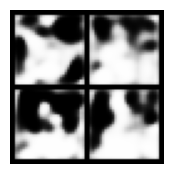

[Epoch 1/100]  [D loss: 0.616716, acc: 76%] [G loss: 0.609633]


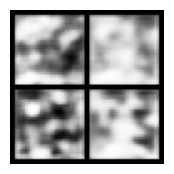

[Epoch 2/100]  [D loss: 0.593630, acc: 85%] [G loss: 0.590102]


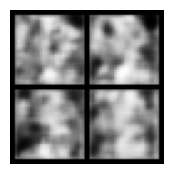

[Epoch 3/100]  [D loss: 0.582618, acc: 89%] [G loss: 0.540145]


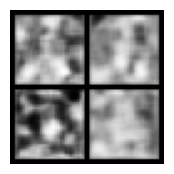

[Epoch 4/100]  [D loss: 0.537735, acc: 89%] [G loss: 0.568842]


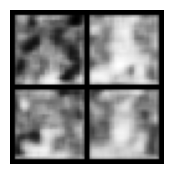

[Epoch 5/100]  [D loss: 0.510771, acc: 96%] [G loss: 0.540452]


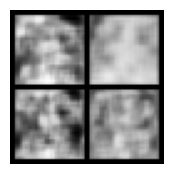

[Epoch 6/100]  [D loss: 0.520215, acc: 91%] [G loss: 0.563439]


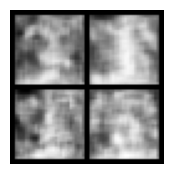

[Epoch 7/100]  [D loss: 0.520633, acc: 92%] [G loss: 0.523291]


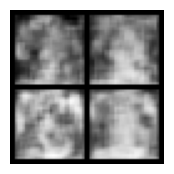

[Epoch 8/100]  [D loss: 0.528149, acc: 94%] [G loss: 0.512245]


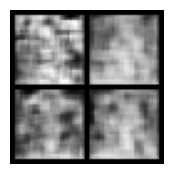

[Epoch 9/100]  [D loss: 0.524558, acc: 93%] [G loss: 0.561672]


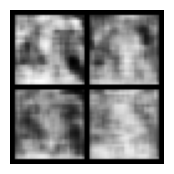

[Epoch 10/100]  [D loss: 0.514333, acc: 96%] [G loss: 0.518414]


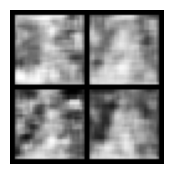

[Epoch 11/100]  [D loss: 0.534951, acc: 95%] [G loss: 0.576645]


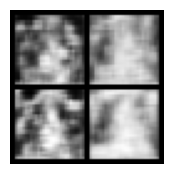

[Epoch 12/100]  [D loss: 0.541824, acc: 93%] [G loss: 0.525275]


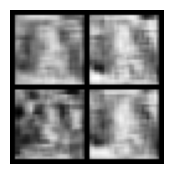

[Epoch 13/100]  [D loss: 0.546994, acc: 91%] [G loss: 0.537334]


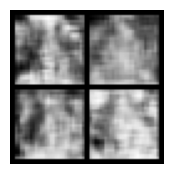

[Epoch 14/100]  [D loss: 0.535357, acc: 94%] [G loss: 0.511000]


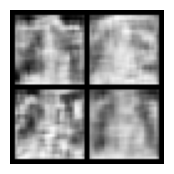

[Epoch 15/100]  [D loss: 0.539804, acc: 92%] [G loss: 0.558210]


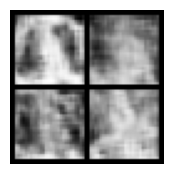

[Epoch 16/100]  [D loss: 0.532731, acc: 94%] [G loss: 0.523809]


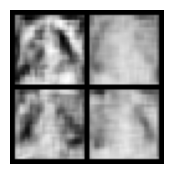

[Epoch 17/100]  [D loss: 0.514376, acc: 96%] [G loss: 0.531057]


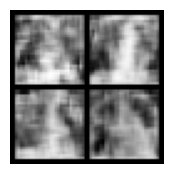

[Epoch 18/100]  [D loss: 0.513860, acc: 95%] [G loss: 0.517823]


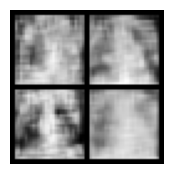

[Epoch 19/100]  [D loss: 0.552439, acc: 92%] [G loss: 0.474091]


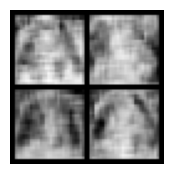

[Epoch 20/100]  [D loss: 0.545460, acc: 90%] [G loss: 0.580457]


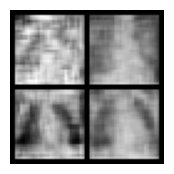

[Epoch 21/100]  [D loss: 0.512594, acc: 95%] [G loss: 0.521438]


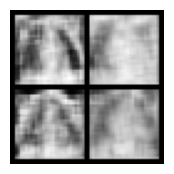

[Epoch 22/100]  [D loss: 0.524352, acc: 90%] [G loss: 0.530269]


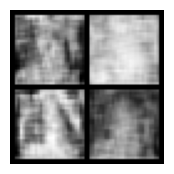

[Epoch 23/100]  [D loss: 0.531312, acc: 94%] [G loss: 0.519611]


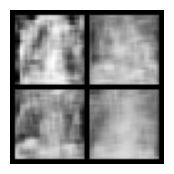

[Epoch 24/100]  [D loss: 0.497736, acc: 91%] [G loss: 0.582289]


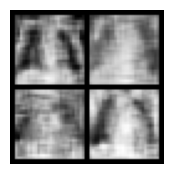

[Epoch 25/100]  [D loss: 0.517845, acc: 93%] [G loss: 0.565271]


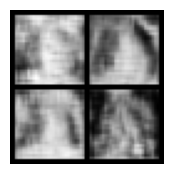

[Epoch 26/100]  [D loss: 0.516342, acc: 94%] [G loss: 0.516232]


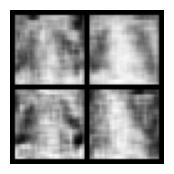

[Epoch 27/100]  [D loss: 0.515362, acc: 95%] [G loss: 0.545204]


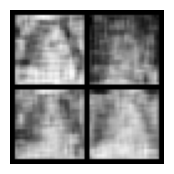

[Epoch 28/100]  [D loss: 0.547083, acc: 90%] [G loss: 0.547321]


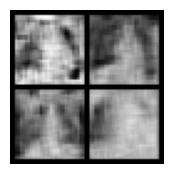

[Epoch 29/100]  [D loss: 0.526160, acc: 91%] [G loss: 0.535188]


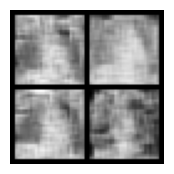

[Epoch 30/100]  [D loss: 0.503640, acc: 96%] [G loss: 0.520770]


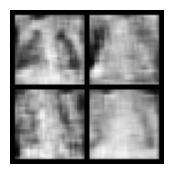

[Epoch 31/100]  [D loss: 0.537276, acc: 93%] [G loss: 0.534309]


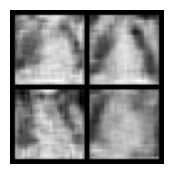

[Epoch 32/100]  [D loss: 0.513060, acc: 95%] [G loss: 0.534446]


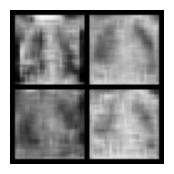

[Epoch 33/100]  [D loss: 0.528134, acc: 92%] [G loss: 0.557564]


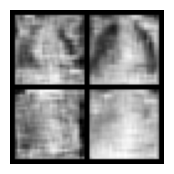

[Epoch 34/100]  [D loss: 0.533055, acc: 92%] [G loss: 0.531342]


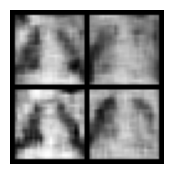

[Epoch 35/100]  [D loss: 0.523914, acc: 94%] [G loss: 0.552371]


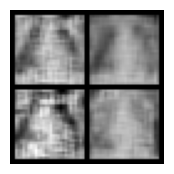

[Epoch 36/100]  [D loss: 0.496837, acc: 95%] [G loss: 0.513216]


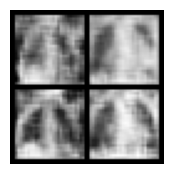

[Epoch 37/100]  [D loss: 0.521741, acc: 95%] [G loss: 0.511510]


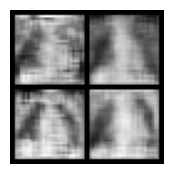

[Epoch 38/100]  [D loss: 0.524521, acc: 95%] [G loss: 0.517791]


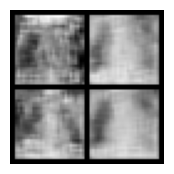

[Epoch 39/100]  [D loss: 0.519146, acc: 96%] [G loss: 0.509476]


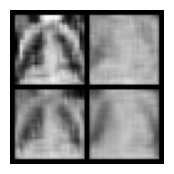

[Epoch 40/100]  [D loss: 0.513183, acc: 95%] [G loss: 0.539876]


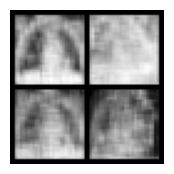

[Epoch 41/100]  [D loss: 0.515234, acc: 93%] [G loss: 0.534991]


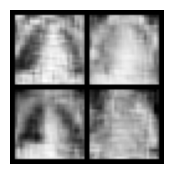

[Epoch 42/100]  [D loss: 0.517898, acc: 94%] [G loss: 0.555457]


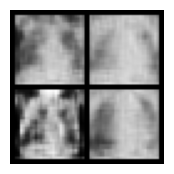

[Epoch 43/100]  [D loss: 0.529013, acc: 93%] [G loss: 0.498733]


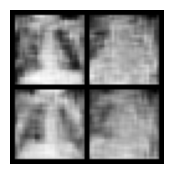

[Epoch 44/100]  [D loss: 0.536531, acc: 94%] [G loss: 0.497046]


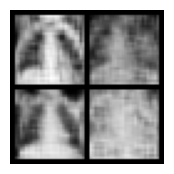

[Epoch 45/100]  [D loss: 0.503930, acc: 95%] [G loss: 0.570409]


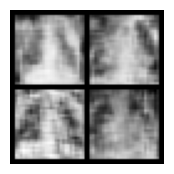

[Epoch 46/100]  [D loss: 0.518648, acc: 97%] [G loss: 0.521547]


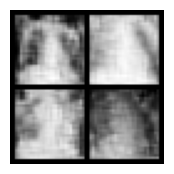

[Epoch 47/100]  [D loss: 0.508404, acc: 96%] [G loss: 0.598766]


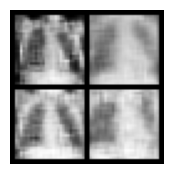

[Epoch 48/100]  [D loss: 0.521958, acc: 94%] [G loss: 0.502789]


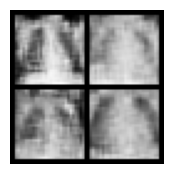

[Epoch 49/100]  [D loss: 0.520528, acc: 95%] [G loss: 0.518995]


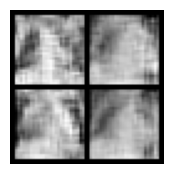

[Epoch 50/100]  [D loss: 0.514597, acc: 93%] [G loss: 0.524098]


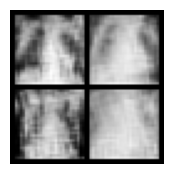

[Epoch 51/100]  [D loss: 0.554349, acc: 94%] [G loss: 0.535602]


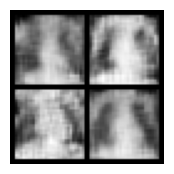

[Epoch 52/100]  [D loss: 0.493638, acc: 95%] [G loss: 0.553815]


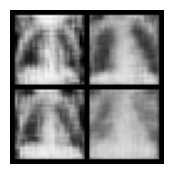

[Epoch 53/100]  [D loss: 0.521311, acc: 95%] [G loss: 0.533276]


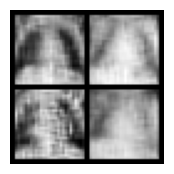

[Epoch 54/100]  [D loss: 0.534175, acc: 97%] [G loss: 0.507953]


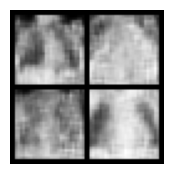

[Epoch 55/100]  [D loss: 0.502504, acc: 97%] [G loss: 0.551101]


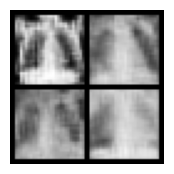

[Epoch 56/100]  [D loss: 0.528217, acc: 96%] [G loss: 0.526577]


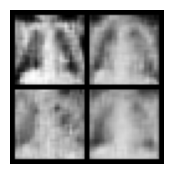

[Epoch 57/100]  [D loss: 0.516382, acc: 98%] [G loss: 0.538229]


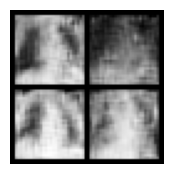

[Epoch 58/100]  [D loss: 0.535357, acc: 96%] [G loss: 0.523380]


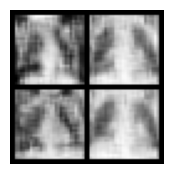

[Epoch 59/100]  [D loss: 0.553770, acc: 92%] [G loss: 0.464000]


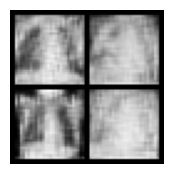

[Epoch 60/100]  [D loss: 0.517904, acc: 97%] [G loss: 0.531280]


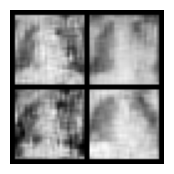

[Epoch 61/100]  [D loss: 0.508153, acc: 96%] [G loss: 0.546606]


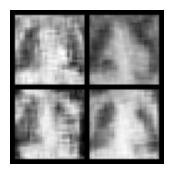

[Epoch 62/100]  [D loss: 0.490239, acc: 96%] [G loss: 0.581816]


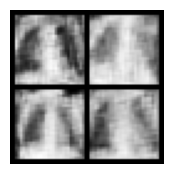

[Epoch 63/100]  [D loss: 0.502489, acc: 96%] [G loss: 0.541059]


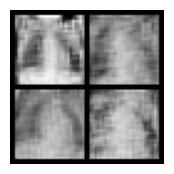

[Epoch 64/100]  [D loss: 0.504226, acc: 96%] [G loss: 0.528186]


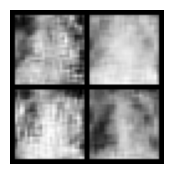

[Epoch 65/100]  [D loss: 0.508973, acc: 96%] [G loss: 0.549035]


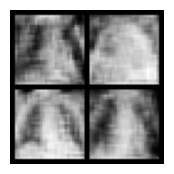

[Epoch 66/100]  [D loss: 0.535678, acc: 94%] [G loss: 0.561505]


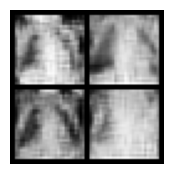

[Epoch 67/100]  [D loss: 0.519035, acc: 97%] [G loss: 0.533892]


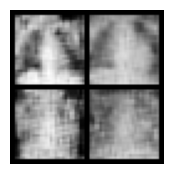

[Epoch 68/100]  [D loss: 0.512888, acc: 94%] [G loss: 0.593578]


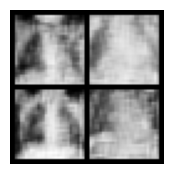

[Epoch 69/100]  [D loss: 0.525769, acc: 98%] [G loss: 0.509929]


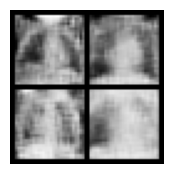

[Epoch 70/100]  [D loss: 0.500268, acc: 96%] [G loss: 0.524637]


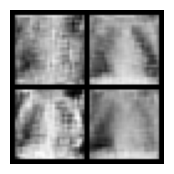

[Epoch 71/100]  [D loss: 0.484541, acc: 96%] [G loss: 0.577758]


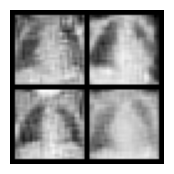

[Epoch 72/100]  [D loss: 0.498389, acc: 95%] [G loss: 0.520644]


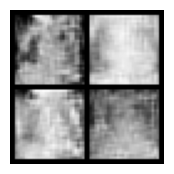

[Epoch 73/100]  [D loss: 0.499499, acc: 97%] [G loss: 0.551308]


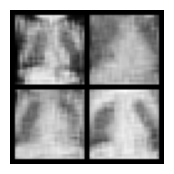

[Epoch 74/100]  [D loss: 0.492070, acc: 97%] [G loss: 0.572760]


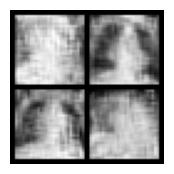

[Epoch 75/100]  [D loss: 0.521455, acc: 96%] [G loss: 0.554006]


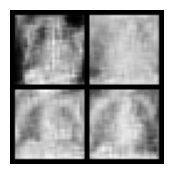

[Epoch 76/100]  [D loss: 0.489540, acc: 98%] [G loss: 0.561802]


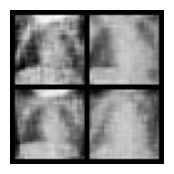

[Epoch 77/100]  [D loss: 0.479953, acc: 96%] [G loss: 0.577573]


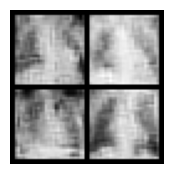

[Epoch 78/100]  [D loss: 0.523769, acc: 96%] [G loss: 0.529788]


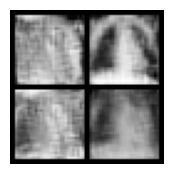

[Epoch 79/100]  [D loss: 0.498307, acc: 96%] [G loss: 0.548042]


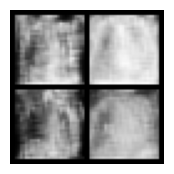

[Epoch 80/100]  [D loss: 0.487864, acc: 95%] [G loss: 0.582640]


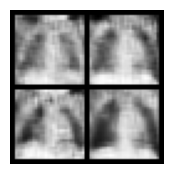

[Epoch 81/100]  [D loss: 0.540923, acc: 95%] [G loss: 0.558741]


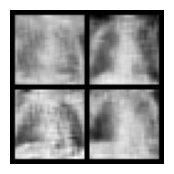

[Epoch 82/100]  [D loss: 0.518554, acc: 95%] [G loss: 0.540073]


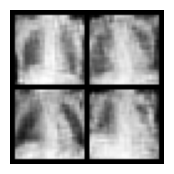

[Epoch 83/100]  [D loss: 0.519049, acc: 93%] [G loss: 0.532504]


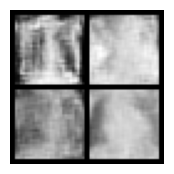

[Epoch 84/100]  [D loss: 0.525441, acc: 96%] [G loss: 0.534726]


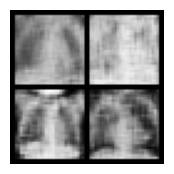

[Epoch 85/100]  [D loss: 0.519907, acc: 96%] [G loss: 0.560889]


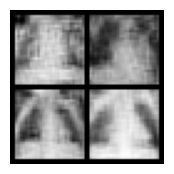

[Epoch 86/100]  [D loss: 0.493578, acc: 96%] [G loss: 0.548098]


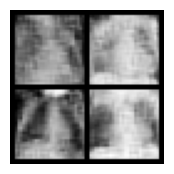

[Epoch 87/100]  [D loss: 0.505221, acc: 97%] [G loss: 0.528755]


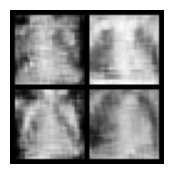

[Epoch 88/100]  [D loss: 0.568876, acc: 94%] [G loss: 0.495478]


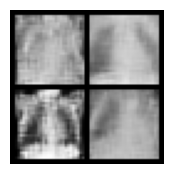

[Epoch 89/100]  [D loss: 0.515463, acc: 96%] [G loss: 0.580462]


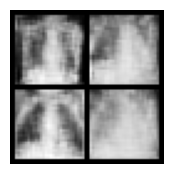

[Epoch 90/100]  [D loss: 0.504460, acc: 94%] [G loss: 0.561056]


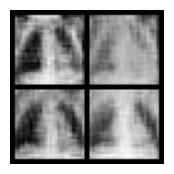

[Epoch 91/100]  [D loss: 0.511424, acc: 96%] [G loss: 0.560508]


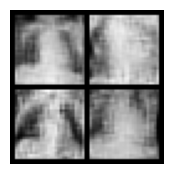

[Epoch 92/100]  [D loss: 0.503039, acc: 95%] [G loss: 0.540847]


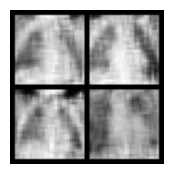

[Epoch 93/100]  [D loss: 0.517712, acc: 95%] [G loss: 0.549329]


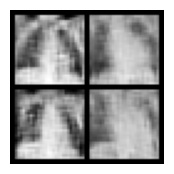

[Epoch 94/100]  [D loss: 0.527090, acc: 97%] [G loss: 0.522627]


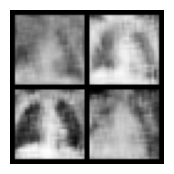

[Epoch 95/100]  [D loss: 0.532316, acc: 97%] [G loss: 0.543926]


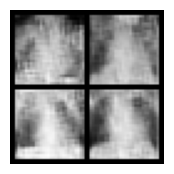

[Epoch 96/100]  [D loss: 0.500719, acc: 97%] [G loss: 0.582129]


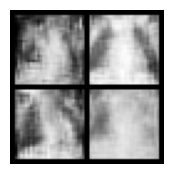

[Epoch 97/100]  [D loss: 0.492615, acc: 98%] [G loss: 0.588948]


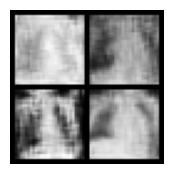

[Epoch 98/100]  [D loss: 0.534140, acc: 95%] [G loss: 0.503621]


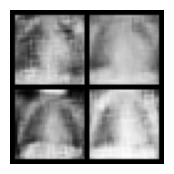

[Epoch 99/100]  [D loss: 0.514850, acc: 96%] [G loss: 0.513422]


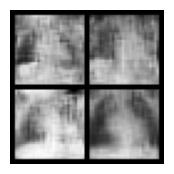

Generator and Discriminator weights saved to /content/drive/MyDrive/Colab Notebooks/MedMNIST/ACGAN_weights


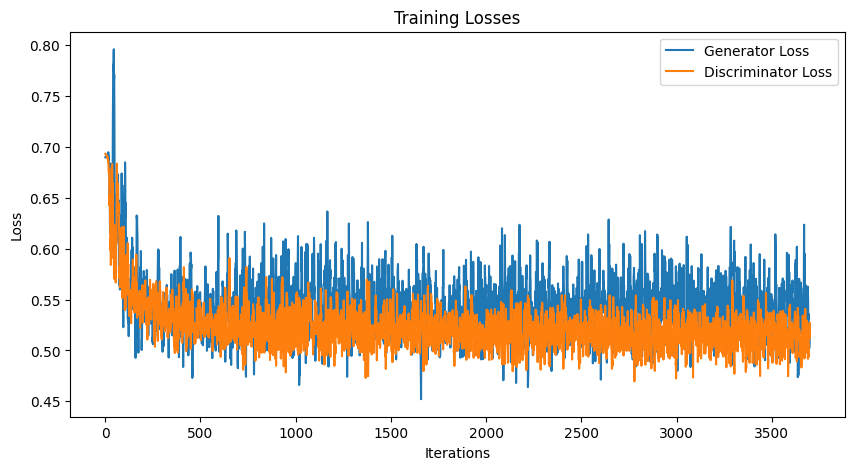

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import init
from torch.nn.utils import spectral_norm

# ========================= Custom Datasets =========================
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# ========================= Generator and Discriminator =========================
class Generator(nn.Module):
    def __init__(self, n_channels, img_size, n_classes, latent_dim):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 64 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, n_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 64, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, n_channels, img_size, n_classes):
        super(Discriminator, self).__init__()
        self.n_channels = n_channels
        self.img_size = img_size
        self.n_classes = n_classes

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(self.n_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = self.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2 *4, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2 *4, self.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


# ========================= Initialize weights =========================
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# ========================= Train ACGAN =========================
def train_acgan(dataloader, generator, discriminator, num_epochs, device):
  g_losses = []
  d_losses = []
  for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

      batch_size = imgs.shape[0]

      # Adversarial ground truths
      valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
      fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(FloatTensor))
      labels = Variable(labels.squeeze().type(LongTensor))

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      # Sample noise and labels as generator input
      z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
      gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

      # Generate a batch of images
      gen_imgs = generator(z, gen_labels)

      # Loss measures generator's ability to fool the discriminator
      validity, pred_label = discriminator(gen_imgs)
      g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))
      g_losses.append(g_loss.cpu().detach().numpy())

      g_loss.backward()
      optimizer_G.step()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Loss for real images
      real_pred, real_aux = discriminator(real_imgs)
      d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

      # Loss for fake images
      fake_pred, fake_aux = discriminator(gen_imgs.detach())
      d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

      # Total discriminator loss
      d_loss = (d_real_loss + d_fake_loss) / 2
      d_losses.append(d_loss.cpu().detach().numpy())

      # Calculate discriminator accuracy
      pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
      gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
      d_acc = np.mean(np.argmax(pred, axis=1) == gt)

      d_loss.backward()
      optimizer_D.step()

    print(
        "[Epoch %d/%d]  [D loss: %f, acc: %d%%] [G loss: %f]"
        % (epoch, num_epochs, d_loss.item(), 100 * d_acc, g_loss.item())
    )

    fake, _ = sample_image(generator, 2)
    show_image_grid(fake, 2, True)
  return g_losses, d_losses

# ========================= Main function =========================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    seed = 42
    torch.manual_seed(seed)

    batch_size = 32
    num_epochs = 100
    latent_dim = 16
    lr = 0.0005
    beta1 = 0.5

    dataset_root = '/content/drive/MyDrive/Colab Notebooks/MedMNIST/output_images/train'
    dataset = CustomImageDataset(root_dir=dataset_root)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    # Loss functions
    adversarial_loss = torch.nn.BCELoss()
    auxiliary_loss = torch.nn.CrossEntropyLoss()

    sample_data, _ = train_dataset[0]
    n_channel = sample_data.shape[0]
    img_size = sample_data.shape[1]
    n_classes = len(list(set(train_dataset.labels.squeeze())))

    # Initialize generator and discriminator
    generator = Generator(n_channel, img_size, n_classes, latent_dim)
    discriminator = Discriminator(n_channel, img_size, n_classes)

    generator.to(device)
    discriminator.to(device)

    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    generated_images_dir = '/content/drive/MyDrive/Colab Notebooks/MedMNIST/generated_images_acgan'
    os.makedirs(generated_images_dir, exist_ok=True)

    gen_losses, disc_losses = train_acgan(
        dataloader, generator, discriminator, num_epochs, device)

    save_dir = "/content/drive/MyDrive/Colab Notebooks/MedMNIST/ACGAN_weights"
    os.makedirs(save_dir, exist_ok=True)

    torch.save(generator.state_dict(), os.path.join(save_dir, 'ACGAN_generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_dir, 'ACGAN_discriminator.pth'))

    print(f"Generator and Discriminator weights saved to {save_dir}")


    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()

## ACGAN data augmentation

In [ ]:
# load ACGAN model
sample_data, _ = train_dataset[0]
n_channel = sample_data.shape[0]
img_size = sample_data.shape[1]
n_classes = len(list(set(train_dataset.labels.squeeze())))

latent_dim = 16
weights_path = "/content/drive/MyDrive/Colab Notebooks/MedMNIST/ACGAN_weights/ACGAN_generator.pth"

# Initialize generator and load pretrained weights
generator = Generator(n_channel, img_size, n_classes, latent_dim)
generator.load_state_dict(torch.load(weights_path, weights_only=True))
generator.to(device)

Generator(
  (label_emb): Embedding(2, 16)
  (l1): Sequential(
    (0): Linear(in_features=16, out_features=3136, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
train_imgs = torch.tensor(np.array([t for t,l in train_dataset])).to(device)
train_labels = torch.tensor(train_dataset.labels.squeeze()).to(device)
label_counts = Counter(train_labels.cpu().numpy().astype(float))
label_counts

Counter({1.0: 3494, 0.0: 1214})

In [ ]:
target_sample = max(label_counts.values())
# target_sample = 5000
gen_imgs, gen_labels = torch.tensor([]).to(device), torch.tensor([]).to(device)

for label, count in label_counts.items():
  label = torch.tensor(label)
  gen_target = target_sample - count

  while gen_target > 0:
    if gen_target >= 4:
      gen_img, gen_label = sample_image(generator, 2, label) # generate 4 img at once
      gen_target -= 4
    else:
      gen_img, gen_label = sample_image(generator, 1, label) # generate 1 img at a time
      gen_target -= 1
    gen_imgs = torch.cat([gen_imgs, gen_img], dim=0)
    gen_labels = torch.cat([gen_labels, gen_label], dim=0)

train_imgs = torch.cat([train_imgs, gen_imgs], dim=0)
train_labels = torch.cat([train_labels, gen_labels], dim=0)

In [ ]:
label_counts = Counter(train_labels.cpu().numpy().astype(int))
label_counts

Counter({1: 3494, 0: 3494})

In [ ]:
train_imgs_np = train_imgs.cpu().detach().numpy()  # Convert images to NumPy
labels_np = train_labels.cpu().numpy() if isinstance(train_labels, torch.Tensor) else np.array(train_labels)

generated_images_dir = '/content/drive/MyDrive/Colab Notebooks/MedMNIST/generated_images_acgan'
os.makedirs(generated_images_dir, exist_ok=True)

generated_npz_path = os.path.join(generated_images_dir, 'train_data_acgan.npz')
# Save the images and labels into an .npz file
np.savez_compressed(generated_npz_path, images=train_imgs_np, labels=labels_np)

print("Data saved successfully to train_data_acgan.npz")

Data saved successfully to train_data_acgan.npz


## Prediction with ACGAN augmented images

In [ ]:

data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])


generated_npz_path = '/content/drive/MyDrive/Colab Notebooks/MedMNIST/generated_images_acgan/train_data_acgan.npz'
augmented_train_data = np.load(generated_npz_path)

# Access images and labels
loaded_imgs = torch.tensor(augmented_train_data['images'])
loaded_labels = torch.tensor(augmented_train_data['labels'])

print(f"Images shape: {loaded_imgs.shape}")
print(f"Labels shape: {loaded_labels.shape}")

train_dataset = data.TensorDataset(loaded_imgs.detach(), loaded_labels.detach().long())

DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/MedMNIST'

test_dataset = DataClass(
    split='test',
    transform=data_transform,
    download=download,
    root=DATA_ROOT
)
val_dataset = DataClass(
    split='val',
    transform=data_transform,
    download=download,
    root=DATA_ROOT
)

pil_dataset = DataClass(
    split='train',
    download=download,
    root=DATA_ROOT
)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print(train_dataset)
print("===================")
print(test_dataset)


Images shape: torch.Size([6988, 1, 28, 28])
Labels shape: torch.Size([6988])
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /content/drive/MyDrive/Colab Notebooks/MedMNIST
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


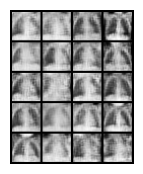

In [ ]:
# show 20 generate images
show_image_grid(loaded_imgs[-20:], 4, True)

# DCGAN

## DCGAN

[Epoch 1/100] [Batch 0/10] [D loss: 0.6851] [G loss: 1.1769]
[Epoch 2/100] [Batch 0/10] [D loss: 0.1828] [G loss: 6.2698]
[Epoch 3/100] [Batch 0/10] [D loss: 0.1689] [G loss: 5.3645]
[Epoch 4/100] [Batch 0/10] [D loss: 0.1667] [G loss: 5.9574]
[Epoch 5/100] [Batch 0/10] [D loss: 0.1733] [G loss: 3.7494]
[Epoch 6/100] [Batch 0/10] [D loss: 0.1667] [G loss: 6.5003]
[Epoch 7/100] [Batch 0/10] [D loss: 0.3170] [G loss: 2.9586]
[Epoch 8/100] [Batch 0/10] [D loss: 0.1837] [G loss: 4.3815]
[Epoch 9/100] [Batch 0/10] [D loss: 0.1883] [G loss: 4.1966]
[Epoch 10/100] [Batch 0/10] [D loss: 0.2636] [G loss: 3.0632]
[Epoch 11/100] [Batch 0/10] [D loss: 0.2042] [G loss: 3.5541]
[Epoch 12/100] [Batch 0/10] [D loss: 0.6746] [G loss: 2.4107]
[Epoch 13/100] [Batch 0/10] [D loss: 0.5034] [G loss: 1.6889]
[Epoch 14/100] [Batch 0/10] [D loss: 0.4353] [G loss: 1.9870]
[Epoch 15/100] [Batch 0/10] [D loss: 0.3676] [G loss: 2.2924]
[Epoch 16/100] [Batch 0/10] [D loss: 0.2165] [G loss: 2.9396]
[Epoch 17/100] [B

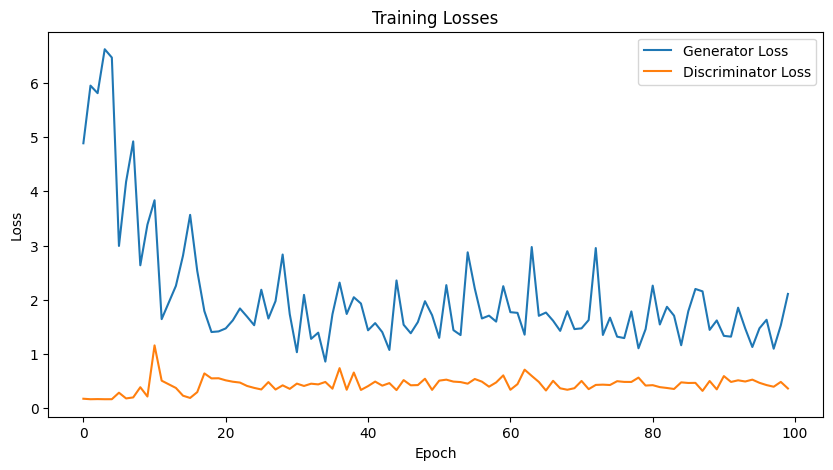

Total 2280 images saved to /home/wsl/classwork/7015/ass1/MedMNIST/examples/generated_images_0108.


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import init
from torch.nn.utils import spectral_norm

# ========================= Custom Datasets =========================
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(root_dir, fname) for fname in os.listdir(root_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# ========================= Generator and Discriminator =========================
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            spectral_norm(nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ========================= Initialize weights =========================
def weights_init_improved(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0)

# ========================= Training DCGAN =========================
def train_dcgan(dataloader, generator, discriminator, num_epochs, device,
                nz, generated_images_dir, save_interval=1):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    gen_loss_history = []
    disc_loss_history = []

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    for epoch in range(num_epochs):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Training the Discriminator
            discriminator.zero_grad()
            label_real = torch.ones(batch_size, device=device) * 0.9
            label_fake = torch.zeros(batch_size, device=device)

            output_real = discriminator(real_images)
            lossD_real = criterion(output_real, label_real)

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            lossD_fake = criterion(output_fake, label_fake)

            lossD = (lossD_real + lossD_fake) / 2
            lossD.backward()
            optimizerD.step()

            # Training the Generator
            generator.zero_grad()
            output_fake = discriminator(fake_images)
            lossG = criterion(output_fake, label_real)
            lossG.backward()
            optimizerG.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {lossD.item():.4f}] [G loss: {lossG.item():.4f}]")

        gen_loss_history.append(lossG.item())
        disc_loss_history.append(lossD.item())

        if (epoch + 1) % save_interval == 0:
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            grid = utils.make_grid(fake, padding=2, normalize=True)
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title(f"Generated Images at Epoch {epoch+1}")
            plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
            plt.savefig(os.path.join(generated_images_dir, f"epoch_{epoch+1}.png"))
            plt.close()

    return gen_loss_history, disc_loss_history

# ========================= Generate Image =========================
def generate_images(generator, nz, device, num_images, save_dir, prefix="generated"):
    os.makedirs(save_dir, exist_ok=True)
    generator.eval()
    batch_size = 64
    num_batches = (num_images + batch_size - 1) // batch_size
    current_index = 1

    with torch.no_grad():
        for batch_idx in range(num_batches):
            actual_batch_size = min(batch_size, num_images - (batch_idx * batch_size))
            noise = torch.randn(actual_batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise).detach().cpu()
            for i in range(actual_batch_size):
                img = fake_images[i]
                img = (img + 1) / 2
                img = transforms.ToPILImage()(img)
                file_name = f"{prefix}_{current_index}.png"
                img.save(os.path.join(save_dir, file_name))
                current_index += 1
    print(f"Total {num_images} images saved to {save_dir}.")

# ========================= Main function =========================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    nz = 100
    ngf = 64
    ndf = 64
    nc = 3
    num_epochs = 100
    batch_size = 128

    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset_root = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images/train_0'
    dataset = CustomImageDataset(root_dir=dataset_root, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    generator = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
    discriminator = Discriminator(nc=nc, ndf=ndf).to(device)

    generator.apply(weights_init_improved)
    discriminator.apply(weights_init_improved)

    generated_images_dir = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/generated_images_0108'
    os.makedirs(generated_images_dir, exist_ok=True)

    gen_losses, disc_losses = train_dcgan(
        dataloader, generator, discriminator, num_epochs, device,
        nz, generated_images_dir
    )

    save_dir = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/DCGAN_weights"
    os.makedirs(save_dir, exist_ok=True)

    torch.save(generator.state_dict(), os.path.join(save_dir, 'DCGAN_generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_dir, 'DCGAN_discriminator.pth'))

    print(f"Generator and Discriminator weights saved to {save_dir}")


    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()

    num_images_to_generate = 2280
    generate_images(generator, nz, device, num_images_to_generate, generated_images_dir)


## DCGAN data processing

In [25]:
import os
import numpy as np
from PIL import Image

# Define the data folder path
base_path = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/Merge_data"
folders = ["train", "test", "val"]

# Target image size (ensure all images have the same size, e.g., 28x28)
image_size = (28, 28)

# Initialize a dictionary to store images and labels
data_dict = {
    "train_images": [],
    "train_labels": [],
    "test_images": [],
    "test_labels": [],
    "val_images": [],
    "val_labels": []
}

# Iterate through the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Extract the label from the filename
            label = int(filename.split("label[")[1].split("]")[0])
            
            # Load the image and resize it to the target size
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            image = image.resize(image_size)  # Resize the image
            image_array = np.array(image)
            
            # Append the image and label to the corresponding keys
            key_images = f"{folder}_images"
            key_labels = f"{folder}_labels"
            data_dict[key_images].append(image_array)
            data_dict[key_labels].append(label)

# Convert lists to NumPy arrays
for key in data_dict:
    if "images" in key:
        data_dict[key] = np.array(data_dict[key], dtype=np.uint8)  # Image array
    else:
        data_dict[key] = np.array(data_dict[key], dtype=np.int64)  # Label array

# Save the data to an .npz file
output_path = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/DCGAN_DATA/Merge_DCGAN_data.npz"
np.savez(output_path, **data_dict)

print(f"Data has been saved to {output_path}")


Data has been saved to /home/wsl/classwork/7015/ass1/MedMNIST/examples/DCGAN_DATA/Merge_data.npz


## Image Binary Classification After DCGAN Data Enhancement

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomPneumoniaMNIST(Dataset):
    def __init__(self, npz_path, split='train', transform=None):
        if not os.path.exists(npz_path):
            raise FileNotFoundError(f"The .npz file '{npz_path}' does not exist.")

        with np.load(npz_path, allow_pickle=True) as data:
            images_key = f"{split}_images"
            labels_key = f"{split}_labels"
            if images_key not in data or labels_key not in data:
                raise KeyError(f"'{images_key}' or '{labels_key}' does not exist in the .npz file.")
            self.images = data[images_key]
            self.labels = data[labels_key]

        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx][0]

        img = Image.fromarray(img, mode='L')

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/MedMNIST/generated_images_label_1224'
npz_path = os.path.join(DATA_ROOT, 'pneumoniamnist.npz')

train_dataset = CustomPneumoniaMNIST(
    npz_path=npz_path,
    split='train',
    transform=data_transform
)
test_dataset = CustomPneumoniaMNIST(
    npz_path=npz_path,
    split='test',
    transform=data_transform
)
val_dataset = CustomPneumoniaMNIST(
    npz_path=npz_path,
    split='val',
    transform=data_transform
)

pil_dataset = CustomPneumoniaMNIST(
    npz_path=npz_path,
    split='train',
    transform=None
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print(train_dataset)
print("===================")
print(test_dataset)


In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 46/46 [00:11<00:00,  3.90it/s]


In [ ]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split, root='/content/drive/MyDrive/Colab Notebooks/MedMNIST/generated_images_label_1224')
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.999  acc:0.979
test  auc: 0.953  acc:0.885


# Normal Data Augmentation

## Augmentation

In [26]:
import os
from PIL import Image
import torchvision.transforms as transforms

def augment_with_flipping_and_renaming(input_dir, output_dir, start_index=4708, end_index=6987):
    os.makedirs(output_dir, exist_ok=True)

    horizontal_flip = transforms.RandomHorizontalFlip(p=1.0)
    vertical_flip = transforms.RandomVerticalFlip(p=1.0)

    current_index = start_index

    for img_name in sorted(os.listdir(input_dir)):
        if current_index > end_index:
            print("Reached the maximum index. Stopping augmentation.")
            break

        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_dir, img_name)
            img = Image.open(img_path).convert('RGB')

            try:
                label = int(img_name.split('_')[-1].split('[')[1].split(']')[0])
            except (IndexError, ValueError):
                print(f"Skipping file: {img_name}, no valid tag information found.")
                continue

            # Save horizontally flipped image
            if current_index <= end_index:
                h_flipped_img = horizontal_flip(img)
                new_file_name = f"train_{current_index}_label[{label}].png"
                h_flipped_img.save(os.path.join(output_dir, new_file_name))
                print(f"Saved: {new_file_name}")
                current_index += 1

            # Save vertically flipped image
            if current_index <= end_index:
                v_flipped_img = vertical_flip(img)
                new_file_name = f"train_{current_index}_label[{label}].png"
                v_flipped_img.save(os.path.join(output_dir, new_file_name))
                print(f"Saved: {new_file_name}")
                current_index += 1

            # Save horizontally and vertically flipped image
            if current_index <= end_index:
                hv_flipped_img = vertical_flip(h_flipped_img)
                new_file_name = f"train_{current_index}_label[{label}].png"
                hv_flipped_img.save(os.path.join(output_dir, new_file_name))
                print(f"Saved: {new_file_name}")
                current_index += 1

input_dir = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/output_images/train_0"
output_dir = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/train_augmented"

augment_with_flipping_and_renaming(input_dir, output_dir, start_index=4708, end_index=6987)

print(f"All images are enhanced up to index 6987 and saved to {output_dir}")


Saved: train_4708_label[0].png
Saved: train_4709_label[0].png
Saved: train_4710_label[0].png
Saved: train_4711_label[0].png
Saved: train_4712_label[0].png
Saved: train_4713_label[0].png
Saved: train_4714_label[0].png
Saved: train_4715_label[0].png
Saved: train_4716_label[0].png
Saved: train_4717_label[0].png
Saved: train_4718_label[0].png
Saved: train_4719_label[0].png
Saved: train_4720_label[0].png
Saved: train_4721_label[0].png
Saved: train_4722_label[0].png
Saved: train_4723_label[0].png
Saved: train_4724_label[0].png
Saved: train_4725_label[0].png
Saved: train_4726_label[0].png
Saved: train_4727_label[0].png
Saved: train_4728_label[0].png
Saved: train_4729_label[0].png
Saved: train_4730_label[0].png
Saved: train_4731_label[0].png
Saved: train_4732_label[0].png
Saved: train_4733_label[0].png
Saved: train_4734_label[0].png
Saved: train_4735_label[0].png
Saved: train_4736_label[0].png
Saved: train_4737_label[0].png
Saved: train_4738_label[0].png
Saved: train_4739_label[0].png
Saved: t

## Augmented data processing


In [27]:
import os
import numpy as np
from PIL import Image

# Define the data folder path
base_path = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/Merge_data_aug"
folders = ["train", "test", "val"]

# Target image size (ensure all images have the same size, e.g., 28x28)
image_size = (28, 28)

# Initialize a dictionary to store images and labels
data_dict = {
    "train_images": [],
    "train_labels": [],
    "test_images": [],
    "test_labels": [],
    "val_images": [],
    "val_labels": []
}

# Iterate through the folders
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Extract the label from the filename
            label = int(filename.split("label[")[1].split("]")[0])
            
            # Load the image and resize it to the target size
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert("L")  # Convert to grayscale
            image = image.resize(image_size)  # Resize the image
            image_array = np.array(image)
            
            # Append the image and label to the corresponding keys
            key_images = f"{folder}_images"
            key_labels = f"{folder}_labels"
            data_dict[key_images].append(image_array)
            data_dict[key_labels].append(label)

# Convert lists to NumPy arrays
for key in data_dict:
    if "images" in key:
        data_dict[key] = np.array(data_dict[key], dtype=np.uint8)  # Image array
    else:
        data_dict[key] = np.array(data_dict[key], dtype=np.int64)  # Label array

# Save the data to an .npz file
output_path = "/home/wsl/classwork/7015/ass1/MedMNIST/examples/Augment_data/Merge_aug_data.npz"
np.savez(output_path, **data_dict)

print(f"Data has been saved to {output_path}")


Data has been saved to /home/wsl/classwork/7015/ass1/MedMNIST/examples/Augment_data/Merge_aug_data.npz


## Image Binary Classification After augmented Data Enhancement